## ch20 Better Models with ICE, Partial Dependence, Monotonic Constraints, and Calibration
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.14</div>
<div style="text-align: right"> Last update: 2023.8.14</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

이 장에서는 XGBoost 모델의 해석 가능성과 성능을 개선하는 데 사용할 수 있는 몇 가지 고급 기법을 살펴보겠습니다. 

여기서는 개별 조건부 Individual ConditionalExpectation(ICE), Partial Dependence Plots 플롯(PDP)에 대해 설명합니다. 
이러한 강력한 시각화 도구를 사용하면 입력 기능이 모델의 예측에 어떤 영향을 미치는지 이해할 수 있습니다.

또한 과적합을 방지하고 일반화 성능을 개선하기 위해 XGBoost 모델을 제약하는 방법도 살펴봅니다.  
이 장에서는 XGBoost 모델에서 가치 있는 인사이트를 추출하는 데 사용할 수 있는 몇 가지 중요한 기법에 대한 포괄적인 개요를 제공합니다.

### 20.1 ICE Plots

Individual Conditional Expectation (ICE) plot은 하나의 입력 변수가 머신 러닝 모델의 출력에 미치는 영향을 시각화하는 데 유용한 도구입니다.  
XGBoost의 맥락에서 ICE 플롯은 각 피처가 모델의 최종 예측에 어떻게 기여하는지 이해하는 데 도움이 될 수 있습니다.  

이 섹션에서는 Python을 사용하여 XGBoost 모델에 대한 ICE 플롯을 만드는 방법을 살펴봅니다.  
ICE 플롯은 특정 입력 특징의 값이 변할 때 단일 관측값에 대한 머신 러닝 모델의 예측 값을 보여줍니다.  

즉, ICE 플롯은 한 입력 특징의 값을 점진적으로 변경하면서 고정 인스턴스에 대한 모델의 출력을 표시합니다.  
플롯의 각 선은 입력 특징이 변경될 때 특정 인스턴스에 대한 예측된 출력을 나타냅니다.  
각 선의 모양과 기울기를 살펴보면 모델이 해당 입력 특징을 사용하여 예측을 수행하는 방식에 대한 인사이트를 얻을 수 있습니다.  
ICE 플롯은 단일 입력 특징과 모델의 예측 간의 관계를 자세히 보여 줍니다. 

단일 샘플에 대한 ICE 플롯을 만들려면 다음 단계를 따르세요:

1. 분석할 입력 피처를 선택하고 해당 피처의 변경할 값 범위를 선택합니다.  

2. 다른 모든 입력 피처의 값을 관심 인스턴스에 대해 관찰된 값으로 고정합니다.  

3. 1단계에서 선택한 값에 대해 선택한 입력 특징을 변경합니다.  

4. 선택한 입력 피처의 각 값에 대해 관심 있는 특정 인스턴스에 대한 모델의 해당 예측을 계산합니다.  

5. 4단계에서 얻은 값을 입력 특징의 해당 값에 대해 플롯하여 ICE 플롯에 한 줄을 만듭니다.  

In [9]:
xgb_def = xgb.XGBClassifier(random_state=42)
xgb_def.fit(X_train, y_train)
xgb_def.score(X_test, y_test)

0.7458563535911602

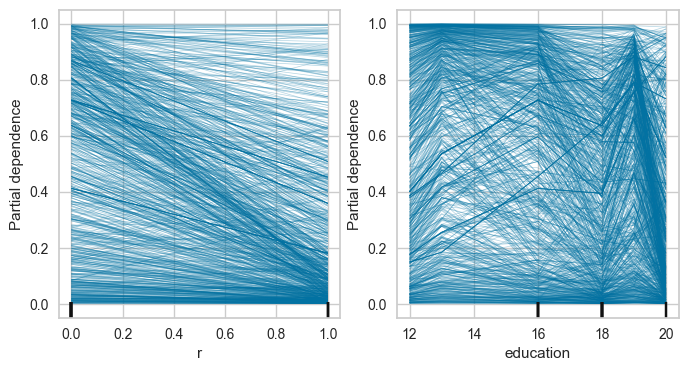

In [10]:
from sklearn.inspection import PartialDependenceDisplay
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
kind='individual', ax=axes)

- R 값이 양수일수록 데이터 과학자의 확률이 높아지는 경향이 있습니다.  
- 교육의 경우에도 교육 수준이 높을수록 데이터 과학자를 선호하는 경향이 있는 것으로 나타났습니다.

???

위 차트로는 무슨 일이 일어나고 있는지 파악하기는 조금 어렵습니다. 

- 이 플롯의 Y축은 최종 레이블인 소프트웨어 엔지니어(1) 또는 데이터 과학자(0)의 확률을 나타냅니다.

- r이 1이 되면 데이터 과학자 쪽이 강하게 밀리는 것입니다.  
- education 플롯의 경우, education 값이 낮을수록 소프트웨어 엔지니어로, 값이 클수록 데이터 과학자로 밀리는 경향이 있습니다.

- 비주얼리제이션을 더 명확하게 만드는 데 도움이 되는 한 가지 기법은 비주얼리제이션이 모두 왼쪽의 동일한 값에서 시작하도록 하는 것입니다. 중앙에 매개 변수를 사용하면 됩니다.

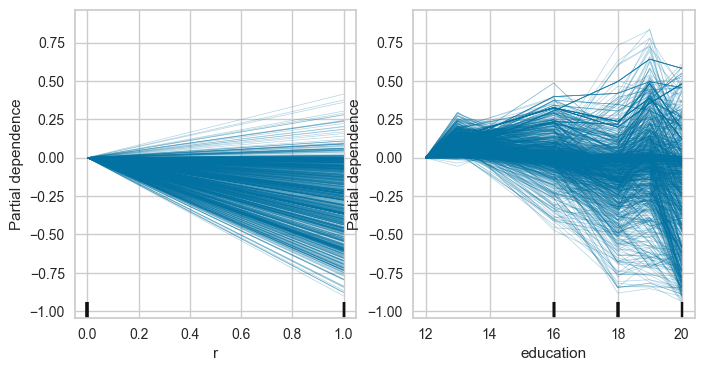

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True,
kind='individual', ax=axes)

또한 이 플롯에서 하단의 눈금은 해당 값을 가진 rows의 수를 시각화하기 위한 것입니다.  
그러나 설문조사 데이터의 구간차원 값으로 인해 education 수준을 식별할 수 없습니다. 

상단에 히스토그램을 표시하여 분포를 확인할 수 있습니다. 이를 통해 데이터의 밀도를 직관적으로 파악할 수 있습니다.

데이터가 많은 지역일수록 더 나은 예측을 하는 경향이 있습니다.   
education의 경우, 교육 기간이 14년 미만인 응답자의 예가 많지 않습니다.  
따라서 예측에 대한 불확실성이 더 커질 수 있습니다.

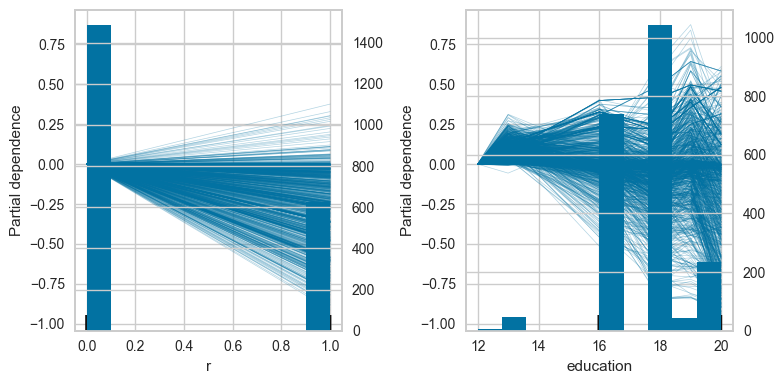

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax_h0 = axes[0].twinx()
ax_h0.hist(X_train.r, zorder=0)
ax_h1 = axes[1].twinx()
ax_h1.hist(X_train.education, zorder=0)
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True,
ice_lines_kw={'zorder':10},
kind='individual', ax=axes)
fig.tight_layout()

저는 예측 확률의 사분위수로 피처를 세분화하고 각 사분위수의 평균으로 선을 만드는 함수인 quantile_ice를 작성했습니다. 이 함수는 또한 히스토그램을 표시할 수도 있습니다.

In [13]:
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True,
                add_hist=False, title='', val_limit=10, ax=None):
  """
    Generate an ICE plot for a binary classifier's predicted probabilities split 
    by quantiles.

    Parameters:
    ----------
    clf : binary classifier
        A binary classifier with a `predict_proba` method.
    X : DataFrame
        Feature matrix to predict on with shape (n_samples, n_features).
    col : str
        Name of column in `X` to plot against the quantiles of predicted probabilities.
    center : bool, default=True
        Whether to center the plot on 0.5.
    q : int, default=10
        Number of quantiles to split the predicted probabilities into.
    color : str or array-like, default='k'
        Color(s) of the lines in the plot.
    alpha : float, default=0.5
        Opacity of the lines in the plot.
    legend : bool, default=True
        Whether to show the plot legend.
    add_hist : bool, default=False
        Whether to add a histogram of the `col` variable to the plot.
    title : str, default=''
        Title of the plot.
    val_limit : num, default=10
        Maximum number of values to test for col.
    ax : Matplotlib Axis, deafault=None
        Axis to plot on.

    Returns:
    -------
    results : DataFrame
        A DataFrame with the same columns as `X`, as well as a `prob` column with 
        the predicted probabilities of `clf` for each row in `X`, and a `group` 
        column indicating which quantile group the row belongs to.
  """                  
  probs = clf.predict_proba(X)
  df = (X
        .assign(probs=probs[:,-1],
               p_bin=lambda df_:pd.qcut(df_.probs, q=q, 
                                        labels=[f'q{n}' for n in range(1,q+1)])
               )
       )
  groups = df.groupby('p_bin')

  vals = X.loc[:,col].unique()
  if len(vals) > val_limit:
    vals = np.linspace(min(vals), max(vals), num=val_limit)
  res = []
  for name,g in groups:
    for val in vals:
      this_X = g.loc[:,X.columns].assign(**{col:val})
      q_prob = clf.predict_proba(this_X)[:,-1]
      res.append(this_X.assign(prob=q_prob, group=name))
  results = pd.concat(res, axis='index')     
  if ax is None:
    fig, ax = plt.subplots(figsize=(8,4))
  if add_hist:
    back_ax = ax.twinx()
    back_ax.hist(X[col], density=True, alpha=.2) 
  for name, g in results.groupby('group'):
    g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
  if legend:
    ax.legend()
  if title:
    ax.set_title(title)
  return results

Let’s plot the 10 quantiles for the education feature. Ideally, these lines do not cross each
other. If they do cross, you might want to debug the model to make sure that it isn’t overfitting
on sparse data.

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,prob,group
3110,40,18.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0.005568,q1
3798,35,18.0,4.0,125000,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0.020992,q1
18640,18,18.0,2.0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0.001421,q1
2621,25,18.0,1.0,125000,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0.007570,q1
4035,30,18.0,2.0,125000,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0.001280,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,35,19.0,10.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.918584,q10
21649,35,19.0,15.0,10000,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.933382,q10
4196,60,19.0,20.0,100000,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0.983405,q10
16608,25,19.0,2.0,10000,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0.914242,q10


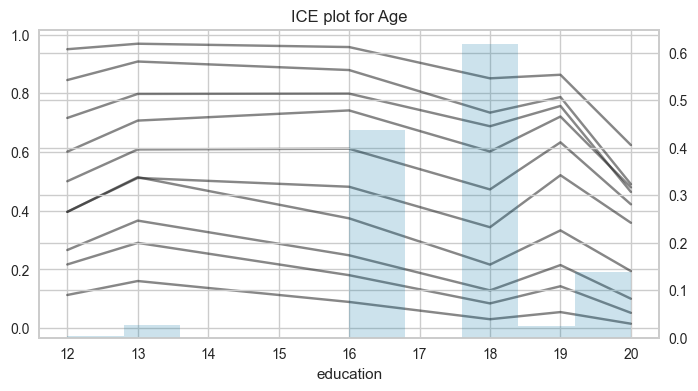

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
quantile_ice(xgb_def, X_train, 'education', q=10, legend=False, add_hist=True, ax=ax,
            title='ICE plot for Age')

### 20.2 ICE Plots with SHAP

ICE plot은 shap를 통해서도 구해진다.  
그러나 다큐먼트가 잘 작성되어 있지는 않다.  
model에는 예측 결과 확률 rows 를 리턴하는 함수를 입력해야 한다.
data에는 입력 raw를 지정한다.  
npoints는 컬럼 수이다.

Text(0.5, 1.0, 'ICE plot (from SHAP)')

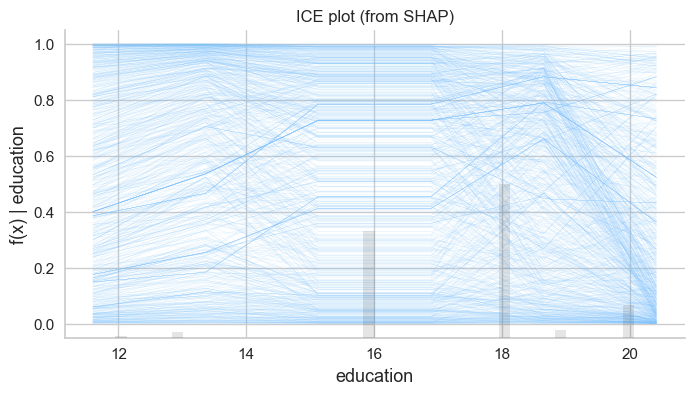

In [15]:
import shap
fig, ax = plt.subplots(figsize=(8,4))

shap.partial_dependence_plot(ind='education', 
    model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
    data=X_train.iloc[0:1000], ice=True, 
    npoints=(X_train.education.nunique()),
    pd_linewidth=0, show=False, ax=ax)
ax.set_title('ICE plot (from SHAP)')

### 20.3 Partial Dependence Plots

위 코드에서 quantile을 1로 설정하면 partial dependence 플롯이 생성됩니다.  
이 것은 ICE 플롯(ICE)의 평균입니다.

부분 의존도 플롯은 입력 변수와 모델의 예측 출력 간의 관계를 이해하기 위해 머신 러닝에서 널리 사용되는 시각화 기법입니다. 

PDP는 다른 모든 변수를 일정하게 유지한 상태에서 특정 입력 변수에 대한 모델의 평균 동작을 보여줍니다.  
이러한 도표를 통해 요약 통계나 단순한 산점도로는 즉시 알 수 없는 데이터의 비선형 관계, 상호 작용 및 기타 중요한 패턴을 식별할 수 있습니다.

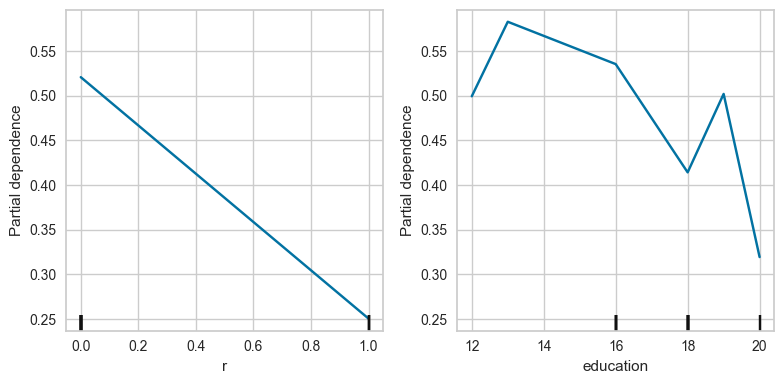

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
kind='average', ax=axes)
fig.tight_layout()

일반적인 제안 방법은 ICE위에 PDP를 그리는 것이다.

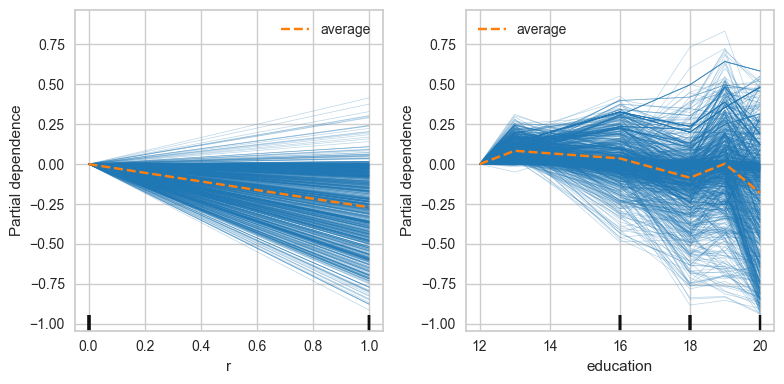

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True, kind='both',
ax=axes)
fig.tight_layout()

Let’s expore the years_exp and Q1_Male plots

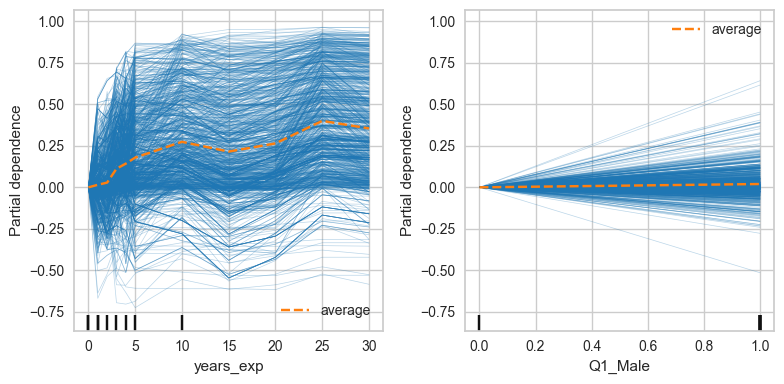

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))

PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['years_exp', 'Q1_Male'],
                                        centered=True, kind='both',
                                        ax=axes)
fig.tight_layout()

It looks like year_exp tends to be monotonically increasing. The Q1_Male plot is flat for
the PDP, but there is some spread for the ICE values, indicating that there is probably an
interaction with other columns.

### 20.4 PDP with SHAP

Text(0.5, 1.0, 'PDP plot (from SHAP)')

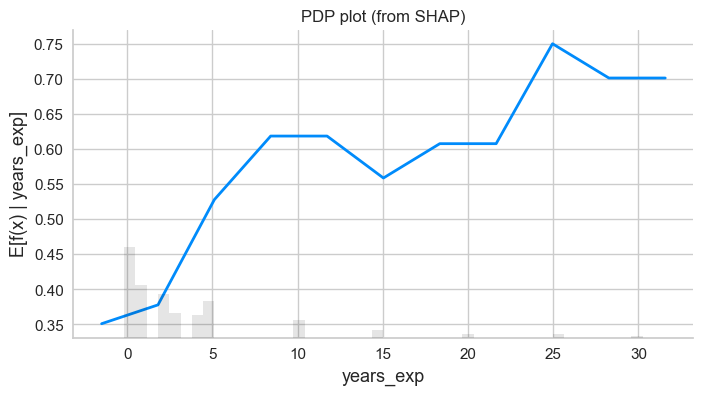

In [19]:
import shap
fig, ax = plt.subplots(figsize=(8,4))
col = 'years_exp'
shap.partial_dependence_plot(ind=col,
model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
data=X_train.iloc[0:1000], ice=False,
npoints=(X_train[col].nunique()),
pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP)')

ice= True로 설정하면 겹쳐서 그릴 수 있다.

Text(0.5, 1.0, 'PDP plot (from SHAP) with ICE Plots')

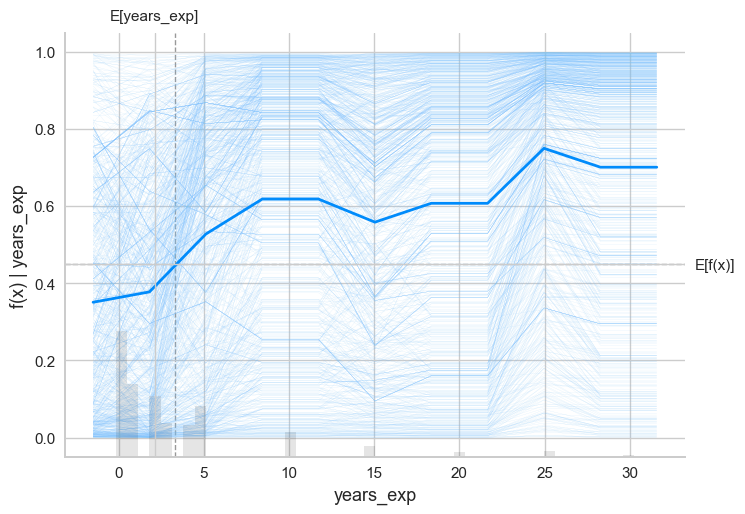

In [20]:
shap.partial_dependence_plot(ind=col, 
                             model=lambda rows: xgb_def.predict_proba(rows)[:,-1],
                             data=X_train.iloc[0:1000], ice=True, 
                             npoints=(X_train[col].nunique()),
                             model_expected_value=True,
                             feature_expected_value=True,
                             pd_linewidth=2, show=False, ax=ax)
ax.set_title('PDP plot (from SHAP) with ICE Plots')

### 20.5 Monotonic Constraints

PDP 및 ICE 플롯은 모델에서 Monotonic Constraints을 식별하는 데 도움이 되는 머신 러닝의 유용한 시각화 도구입니다.

Monotonic Constraints이란 특정 피처의 값이 변할 때 예측 결과가 항상 증가하거나 감소해야 한다는 것을 의미합니다.  
이는 다음과 같은 상황에서 자주 발생합니다.
피처와 타겟 간의 상관관계가 있는 경우입니다.  
상관관계는 인과 관계가 아니라는 표준 면책 조항이 여기에 적용됩니다!???  
ranked 상관관계(스피어만)를 조사하는 것은 이러한 관계를 탐색하는 한 가지 방법입니다.

<Axes: title={'center': 'Spearman Correlation with Target'}>

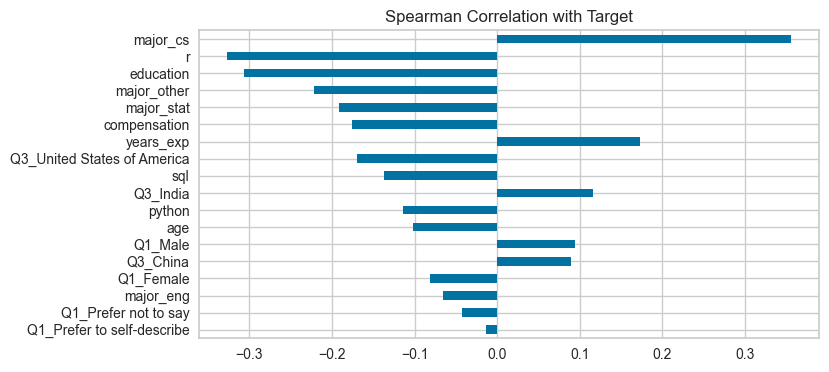

In [21]:
fig, ax = plt.subplots(figsize=(8,4))

(X_test
 .assign(target=y_test)
 .corr(method='spearman')
 .iloc[:-1]
 .loc[:,'target']
 .sort_values(key=np.abs)
 .plot.barh(title='Spearman Correlation with Target', ax=ax)
)

컷오프를 생성하고 해당 컷오프 위의 변수를 탐색할 수 있습니다.  
절대값에 대한 컷오프가 0.2로 설정하자.  
교육 열은 이진이 아니므로 탐색하기에 좋은 후보가 될 수 있습니다.

PDP 및 ICE 플롯은 다른 모든 특징을 일정하게 유지하면서 특징과 예측 결과 간의 관계를 보여줌으로써 단조로운 제약을 식별하는 데 도움이 될 수도 있습니다.   


플롯에 특정 특징에 대한 명확한 증가 또는 감소 추세가 표시되면 단조로운 제약 조건을 나타낼 수 있습니다.

마지막 섹션에서 education PDP를 볼 수 있습니다. 

교육에 대한 PDP 플롯을 살펴보면 선이 거의 단조롭게 나타납니다.   
19에서 작은 범프가 있습니다.   
이 플롯을 보고 데이터를 좀 더 자세히 살펴보게 되었습니다.  
tweak_kag 함수는 전문 학위를 19(19년제 학교)의 값으로 변환합니다.   
대부분의 전문 학위는 3~5년이 걸립니다.

판다스를 사용하여 교육에서 어떤 일이 일어나는지, 그리고 다른 열의 평균값을 살펴보겠습니다:

In [22]:
print(X_train
      .assign(target = y_train)
      .groupby('education')
      .mean()
      .loc[:, ['age', 'years_exp', 'target']]
      )

                 age  years_exp    target
education                                
12.0       30.428571   2.857143  0.714286
13.0       30.369565   6.760870  0.652174
16.0       25.720867   2.849593  0.605691
18.0       28.913628   3.225528  0.393474
19.0       27.642857   4.166667  0.571429
20.0       35.310638   4.834043  0.174468


타겟이 19에서 급증하는 것을 볼 수 있다. 19에 value가 몇개 있는지 보자.

In [23]:
X_train.education.value_counts()

education
18.0    1042
16.0     738
20.0     235
13.0      46
19.0      42
12.0       7
Name: count, dtype: int64

수가 많지 않다. 더 실펴보기 위해 원본 데이터를 보자.  
19는 Professional degree 에서 가져 온 것이다.

In [24]:
print(raw
      .query('Q3.isin(["United States of America", "China", "India"]) '
             'and Q6.isin(["Data Scientist", "Software Engineer"])')
      .query('Q4 == "Professional degree"')
      .pipe(lambda df_:pd.crosstab(index=df_.Q5, columns=df_.Q6))
      )

Q6                                                  Data Scientist  \
Q5                                                                   
A business discipline (accounting, economics, f...               0   
Computer science (software engineering, etc.)                   12   
Engineering (non-computer focused)                               6   
Humanities (history, literature, philosophy, etc.)               2   
I never declared a major                                         0   
Mathematics or statistics                                        2   
Other                                                            2   
Physics or astronomy                                             2   

Q6                                                  Software Engineer  
Q5                                                                     
A business discipline (accounting, economics, f...                  1  
Computer science (software engineering, etc.)                      19  
Engineering

XGBoost에 단조 제약 조건을 추가할지 여부는 모델의 특정 컨텍스트와 목표에 따라 결정됩니다. 

단조 제약 조건을 추가하여 모델이 기능과 결과 간의 특정 관계를 준수하도록 할 수 있습니다. 예를 들어, 재무 위험 모델링과 같이 특징과 결과 간에 명확한 인과 관계가 예상되는 시나리오에서는 단조 제약 조건을 추가하여 모델이 해당 특징의 증가 또는 감소 추세를 예측하도록 할 수 있습니다. 단조 제약 조건을 추가하면 특징과 결과 간의 관계를 명확하게 제한하여 모델의 정확성과 해석 가능성을 개선하는 데 도움이 될 수 있습니다. 또한 모델이 특정 특징에 대해 예측할 수 있는 값의 범위를 제한하여 과적합을 줄이는 데 도움이 될 수 있습니다.

PDP 및 ICE 플롯을 보면 education에 monotonic constraint 조건을 적용하지 않아도 될 데이터가 많지 않은 것으로 보입니다.  

모델이 19라는 값으로 교육 항목에 오버피팅될 가능성이 있습니다.  
모델을 단순화하기 위해 단조 제약 조건을 추가하겠습니다.

또한 years_exp 열에 제약 조건을 추가하겠습니다.  
열 이름을 PDP 플롯의 기울기 부호에 매핑하는 monotone_constraints 매개 변수를 지정합니다.  
years_exp는 증가하므로 1에 매핑합니다. 교육 열은 감소하므로 -1에 매핑합니다. 에 매핑합니다.

In [25]:
xgb_const = xgb.XGBClassifier(random_state=42,
monotone_constraints={'years_exp':1, 'education':-1})
xgb_const.fit(X_train, y_train)
xgb_const.score(X_test, y_test)

0.7546961325966851

제약 조건으로 인해 모델이 개선되고 단순화된 것 같습니다!
한 단계 더 나아가 보겠습니다. Q1_Male에 대한 PDP 라인이 평평했기 때문에 성별 열도 제거합니다.

In [26]:
small_cols = ['age', 'education', 'years_exp', 'compensation', 'python', 'r', 'sql',
              #'Q1_Male', 'Q1_Female', 'Q1_Prefer not to say',
              #'Q1_Prefer to self-describe', 
              'Q3_United States of America', 'Q3_India',
              'Q3_China', 'major_cs', 'major_other', 'major_eng', 'major_stat']
xgb_const2 = xgb.XGBClassifier(random_state=42,
          monotone_constraints={'years_exp':1, 'education':-1})
xgb_const2.fit(X_train[small_cols], y_train)
xgb_const2.score(X_test[small_cols], y_test)

0.7569060773480663

성능이 더 좋아지고 간단해졌다.  
이 두가지 제한사항이 모델을 개선한 것 같다.   
이제 피처 임포턴스를 따져보자.

기본 모델은 R을 중요하게 바라봤다.

<Axes: >

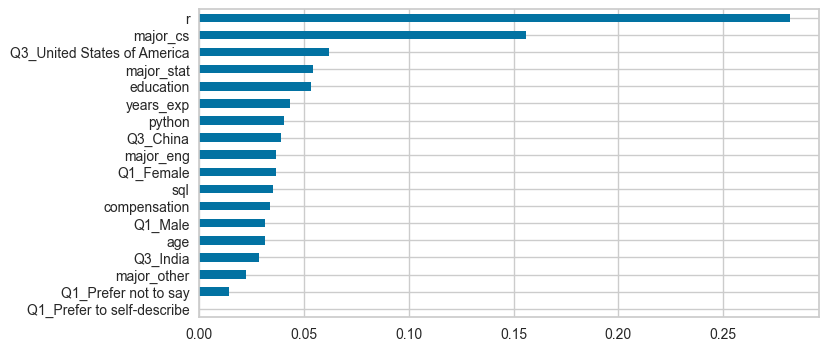

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

제약된 모델의 기능 중요도 값이 약간 더 고르게 분포되어 있는 것으로 보아 해당 모델이 R 열에 덜 주의를 기울이는 것으로 보입니다.

<Axes: >

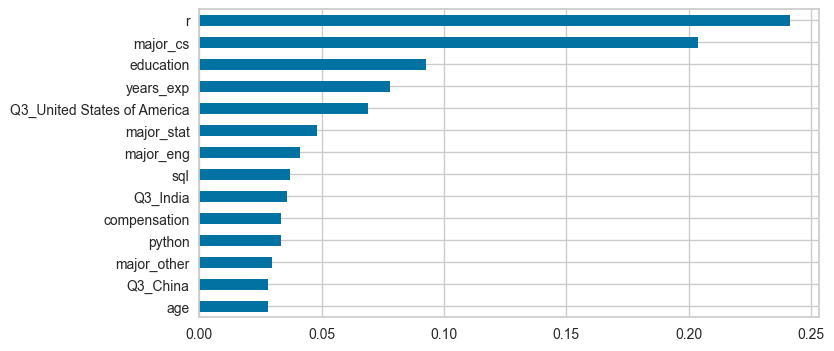

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
(pd.Series(xgb_const2.feature_importances_, index=small_cols)
.sort_values()
.plot.barh(ax=ax)
)

### 20.6 Calibrating a Model

이 섹션에서는 보정을 통해 모델을 미세 조정하는 방법을 살펴봅니다. 보정이란 대상 변수의 실제 확률과 더 잘 일치하도록 모델의 출력을 조정하는 것을 말합니다. 대상 변수가 아닌 (.predict_proba의) 확률을 사용하려면 모델을 보정해야 합니다.

XGBoost를 사용하면 확률 출력값이 대상 변수의 실제 확률과 일치하지 않는 경우가 많습니다. XGBoost 모델은 확률 범위의 끝에 편향된 예측 확률을 생성하는 경향이 있으며, 이는 실제 확률을 과대 또는 과소 평가하는 경우가 많다는 것을 의미합니다. 

이로 인해 순위, 임계값 선택 및 의사 결정과 같이 정확한 확률 추정이 필요한 작업에서 성능이 저하될 수 있습니다.

XGBoost 모델을 보정하려면 플랫 스케일링 또는 등방성 회귀와 같은 보정 방법을 사용하여 모델의 예측 확률을 후처리해야 합니다. 
이러한 방법은 다음과 같습니다. 모델의 예측 확률을 보정된 확률에 매핑하여 대상 변수의 실제 확률과 더 잘 일치하는 보정된 확률에 매핑합니다.
scikit-learn을 사용하여 모델을 보정해 보겠습니다.

시그모이드와 등장성 보정 두 가지 보정 유형을 사용할 수 있습니다. 

시그모이드 보정은 이진 분류기의 예측 확률에 로지스틱 회귀 모델을 맞추고 로지스틱 함수를 사용하여 확률을 변환하는 것을 포함합니다. 

아이소토닉 보정은 비모수적 단조 함수를 예측 확률에 맞추는 것으로, 확률이 증가함에 따라 함수가 증가하도록 하는 것입니다.

두 가지 기법 모두 모델의 확률적 예측의 신뢰성을 향상시킬 수 있지만 유연성과 해석 가능성에서 차이가 있습니다.  
시그모이드 보정은 간단하고 계산적으로 효율적인 방법으로 쉽게 구현할 수 있지만 보정 함수의 파라메트릭 형태를 가정하며 더 복잡한 보정 패턴을 포착하지 못할 수 있습니다.


반면 아이소토닉 보정은 보다 유연하고 데이터 중심적인 방법으로 더 복잡한 보정 패턴을 캡처할 수 있습니다. 하지만 구현하는 데 더 많은 데이터와 계산 리소스가 필요할 수 있습니다.

두 가지 방법을 모두 시도해보고 결과를 비교해 보겠습니다. 기존 모델과 메서드 매개 변수를 CalibratedClassifierCV에 제공해야 합니다. 저는 이미 모델을 맞췄기 때문에 cv=prefit을 사용하고 있습니다. 그런 다음 .fit 메서드를 호출합니다.

In [29]:
from sklearn.calibration import CalibratedClassifierCV
xgb_cal = CalibratedClassifierCV(xgb_def, method='sigmoid', cv='prefit')
xgb_cal.fit(X_test, y_test)
xgb_cal_iso = CalibratedClassifierCV(xgb_def, method='isotonic', cv='prefit')
xgb_cal_iso.fit(X_test, y_test)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=42, ...),
                       method='isotonic')

### 20.7 Calibration Curves

결과를 캘리브레이션 곡선으로 시각화합니다.

보정 곡선은 이진 분류 문제에서 예측된 확률과 이벤트의 실제 빈도 사이의 관계를 그래픽으로 표현한 것입니다. 이 곡선은 다양한 확률 임계값에 대해 예측된 확률(x축)을 양수 클래스의 관찰된 빈도(y축)에 대해 플롯합니다.

보정 곡선은 분류 모델의 예측 확률이 관심 있는 이벤트의 실제 확률과 얼마나 잘 일치하는지 시각적으로 평가합니다. 이상적으로 잘 보정된 모델은 이벤트의 실제 확률과 일치하는 예측 확률을 가져야 하며, 이는 보정 곡선이 대각선에 가까워야 함을 의미합니다.

보정 곡선이 대각선에서 벗어난다면 모델의 예측 확률이 과신하거나 과소신뢰하고 있음을 의미합니다. 과신 모델은 발생할 가능성이 낮은 이벤트에 대해 높은 확률을 예측하는 반면, 과소 모델은 발생할 가능성이 높은 이벤트에 대해 낮은 확률을 예측합니다.

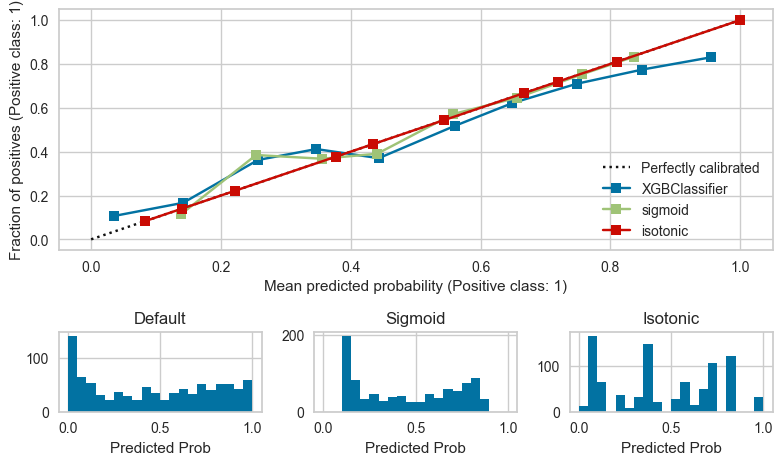

In [30]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,6))
gs = GridSpec(4, 3)
axes = fig.add_subplot(gs[:2, :3])
display = CalibrationDisplay.from_estimator(xgb_def, X_test, y_test, 
                                            n_bins=10, ax=axes)
disp_cal = CalibrationDisplay.from_estimator(xgb_cal, X_test, y_test, 
                                      n_bins=10,ax=axes, name='sigmoid')
disp_cal_iso = CalibrationDisplay.from_estimator(xgb_cal_iso, X_test, y_test, 
                                      n_bins=10, ax=axes, name='isotonic')
row = 2
col = 0
ax = fig.add_subplot(gs[row, col])
ax.hist(display.y_prob, range=(0,1), bins=20)
ax.set(title='Default', xlabel='Predicted Prob')
ax2 = fig.add_subplot(gs[row, 1])
ax2.hist(disp_cal.y_prob, range=(0,1), bins=20)
ax2.set(title='Sigmoid', xlabel='Predicted Prob')
ax3 = fig.add_subplot(gs[row, 2])
ax3.hist(disp_cal_iso.y_prob, range=(0,1), bins=20)
ax3.set(title='Isotonic', xlabel='Predicted Prob')
fig.tight_layout()

The calibration curve suggests that our default model does a respectable job. It is tracking
the diagonal pretty well. But our calibrated models look like they track the diagonal better.
The histograms show the distribution of the default model and the calibrated models.
Let’s look at the score of our calibrated models. It looks like they perform slightly better
(at least for accuracy).

In [31]:
xgb_cal.score(X_test, y_test)

0.7480662983425415

In [32]:
xgb_cal_iso.score(X_test, y_test)

0.7491712707182321

In [33]:
xgb_def.score(X_test, y_test)

0.7458563535911602